In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import xarray as xr
from pathlib import Path
import h5py
import os, sys
sys.path.insert(1, '/home/sbidadi/atom/sbidadi')
from windtools.windtools.amrwind.post_processing  import ABLStatistics, Sampling, addDatetime

In [2]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2 
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

In [3]:
dir0 = Path('/scratch/sbidadi/ai4wind/windai/simulations/maine_sweep/wspd28/lev2_write_netcdf_bcs_test_cpu/post_processing')
f0 = Path(dir0, 'sampling167500.nc')

In [4]:
with Dataset(f0, "r") as template:
    print("template.cmptypes", template.cmptypes)
    print("template.data_model", template.data_model)
    print("template.dimensions", template.dimensions)
    print("template.disk_format", template.disk_format)
    print("template.enumtypes", template.enumtypes)
    print("template.file_format", template.file_format)
    print("template.groups", template.groups)
    print("template.keepweakref", template.keepweakref)
    print("template.name", template.name)
    print("template.parent", template.parent)
    print("template.path", template.path)
    print("template.variables", template.variables)
    print("template.vltypes", template.vltypes)

template.cmptypes {}
template.data_model NETCDF4
template.dimensions {'num_time_steps': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'num_time_steps', size = 23, 'ndim': <class 'netCDF4._netCDF4.Dimension'>: name = 'ndim', size = 3}
template.disk_format HDF5
template.enumtypes {}
template.file_format NETCDF4
template.groups {'xz0': <class 'netCDF4._netCDF4.Group'>
group /xz0:
    sampling_type: PlaneSampler
    ijk_dims: [320 240   1]
    origin: [ 1.875e-10  1.200e+03 -4.000e+02]
    axis1: [2.39250000e+03 0.00000000e+00 1.87469595e-10]
    axis2: [1.8750e-10 0.0000e+00 1.7925e+03]
    offset_vector: [0. 0. 0.]
    offsets: 0.0
    dimensions(sizes): num_points(76800)
    variables(dimensions): float64 coordinates(num_points, ndim), float64 vof(num_time_steps, num_points), float64 velocityx(num_time_steps, num_points), float64 velocityy(num_time_steps, num_points), float64 velocityz(num_time_steps, num_points)
    groups: , 'xz1': <class 'netCDF4._netCDF4.Group'>
group /xz

In [5]:
frequency_output0 = 100

### Grab raw data from .nc file
with h5py.File(f0) as f:
    # Time
    time0 = f['time'][:]
    
    # xz-plane
    xz0_coords_raw = f['xz2']['coordinates'][:]

In [9]:
frequency_output0 = 100

### Grab raw data from .nc file
with h5py.File(f0) as f:
    # Time
    time0 = f['time'][:]
    
    # xz-plane
    xz0_coords_raw = f['xz2']['coordinates'][:]

print(np.shape(time0))
print(np.shape(xz0_coords_raw))

### Reformat xz plane
xz0_xcoords = np.sort(np.unique(np.round(xz0_coords_raw[:,0],6)))
xz0_ycoords = np.sort(np.unique(np.round(xz0_coords_raw[:,1],6)))
xz0_zcoords = np.sort(np.unique(np.round(xz0_coords_raw[:,2],6)))

print(np.shape(xz0_xcoords))
print(np.shape(xz0_ycoords))
print(np.shape(xz0_zcoords))

xz0_coords = {'time':time0, 'x': xz0_xcoords, 'y': xz0_ycoords, 'z': xz0_zcoords}
ds_xz0 = xr.Dataset(xz0_coords)

for var in ['velocityx', 'velocityy', 'velocityz', 'vof']:
    with h5py.File(f0, 'r') as f:
        curr_arr = f['xz2'][var][:]
    arr_reshaped = curr_arr.reshape((len(time0), len(xz0_zcoords), len(xz0_ycoords), len(xz0_xcoords)))
    arr_transposed = np.transpose(arr_reshaped, axes=[0,3,2,1])
    ds_xz0[var] = (('time', 'x', 'y', 'z'), arr_transposed)

(26,)
(65536, 3)
(1024,)
(1,)
(64,)


(26, 1024, 1, 64)
(64, 1024)
(1024, 64)
(64, 1024)


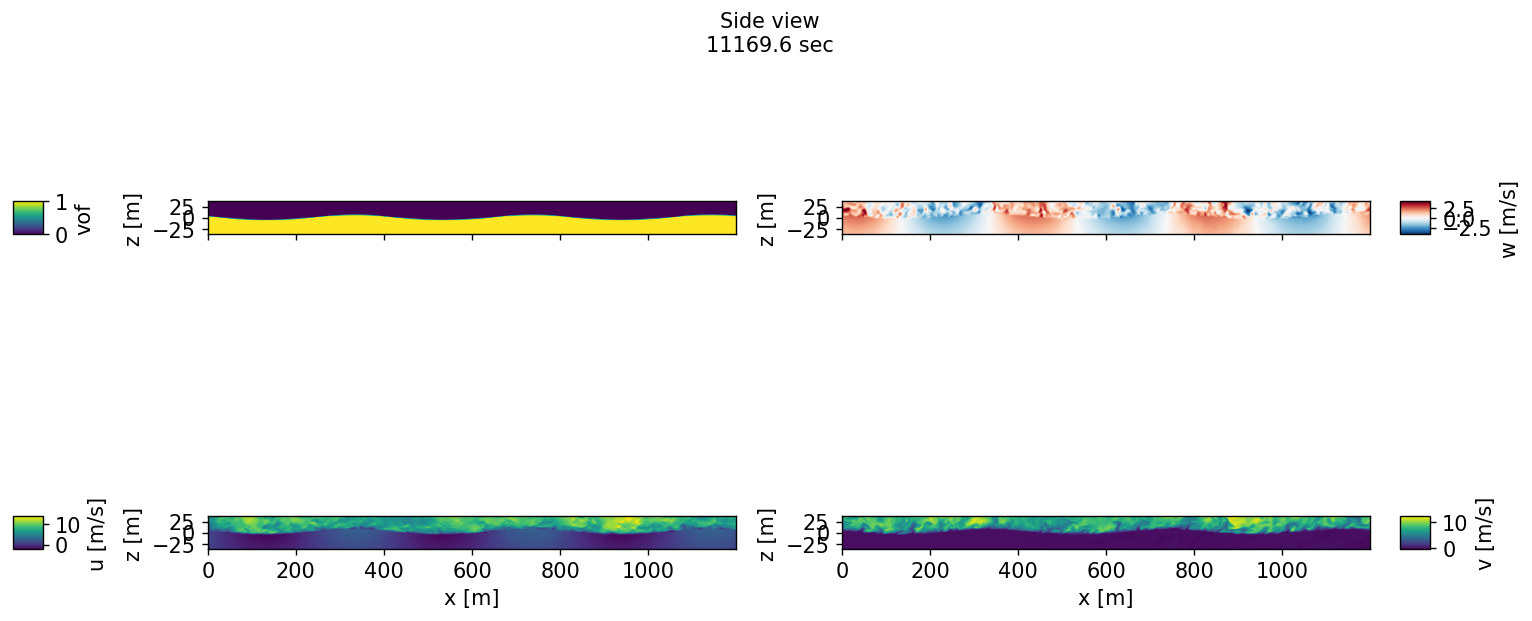

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(12,6), sharex=True, dpi=125)

## Select data
plotvar = 'vof'
if plotvar == 'vof':
    plotmin = 0
    plotmax = 1
else:
    raise NotImplementedError

tind = 0 #-1
yind = 0
zlo_plt, zhi_plt = -400, 800

for axs in ax.flatten():
    axs.set_aspect('equal')
    axs.set_ylabel("z [m]")
    # axs.set_xlim(0, 800)
ax[1,0].set_xlabel("x [m]")
ax[1,1].set_xlabel("x [m]")
    
# ax[-1].set_xlabel("x [m]")
print(np.shape(ds_xz0['velocityx']))

plt.suptitle(f"Side view\n{ds_xz0['time'].values[tind]:.1f} sec")

data00 = ds_xz0['vof'].isel(y=yind, time=tind).sel(z=slice(zlo_plt,zhi_plt)).values.T
print(np.shape(data00))
data01 = ds_xz0['velocityz'].isel(y=yind, time=tind).sel(z=slice(zlo_plt,zhi_plt)).values.T
print(np.shape(ds_xz0['velocityz'].isel(y=yind, time=tind)))
print(np.shape(data01))
data10 = ds_xz0['velocityx'].isel(y=yind, time=tind).sel(z=slice(zlo_plt,zhi_plt)).values.T
data11 = ds_xz0['velocityy'].isel(y=yind, time=tind).sel(z=slice(zlo_plt,zhi_plt)).values.T

min00, max00 = 0, 1
min01, max01 = data01.min(), data01.max()
min10, max10 = data10.min(), data10.max()
min11, max11 = data11.min(), data11.max()

## Plot
im0 = ax[0,0].pcolormesh(ds_xz0['x'],
                   ds_xz0['z'].sel(z=slice(zlo_plt,zhi_plt)),
                   data00,
                   shading='auto',
                   vmin=min00,
                   vmax=max00)

im1 = ax[0,1].pcolormesh(ds_xz0['x'],
                   ds_xz0['z'].sel(z=slice(zlo_plt,zhi_plt)),
                   data01,
                   shading='auto',
                   vmin=min01,
                   vmax=max01,
                   cmap='RdBu_r')
im2 = ax[1,0].pcolormesh(ds_xz0['x'],
                   ds_xz0['z'].sel(z=slice(zlo_plt,zhi_plt)),
                   data10,
                   shading='auto',
                   vmin=min10,
                   vmax=max10)
im3 = ax[1,1].pcolormesh(ds_xz0['x'],
                   ds_xz0['z'].sel(z=slice(zlo_plt,zhi_plt)),
                   data11,
                   shading='auto',
                   vmin=min11,
                   vmax=max11)



## Colorbars
cax0 = fig.add_axes([ax[0,0].get_position().x0-0.13,
                    ax[0,0].get_position().y0,
                    0.02,
                    ax[0,0].get_position().y1-ax[0,0].get_position().y0])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label('vof')
cbar0.ax.tick_params()

cax1 = fig.add_axes([ax[0,1].get_position().x1+0.02,
                    ax[0,1].get_position().y0,
                    0.02,
                    ax[0,1].get_position().y1-ax[0,1].get_position().y0])
cbar1 = fig.colorbar(im1, cax=cax1)
cbar1.set_label('w [m/s]')
cbar1.ax.tick_params()

cax2 = fig.add_axes([ax[1,0].get_position().x0-0.13,
                    ax[1,0].get_position().y0,
                    0.02,
                    ax[1,0].get_position().y1-ax[1,0].get_position().y0])
cbar2 = fig.colorbar(im2, cax=cax2)
cbar2.set_label('u [m/s]')
cbar2.ax.tick_params()

cax3 = fig.add_axes([ax[1,1].get_position().x1+0.02,
                    ax[1,1].get_position().y0,
                    0.02,
                    ax[1,1].get_position().y1-ax[1,1].get_position().y0])
cbar3 = fig.colorbar(im3, cax=cax3)
cbar3.set_label('v [m/s]')
cbar3.ax.tick_params()

# ax.set_ylim(0, 3000)

plt.show()

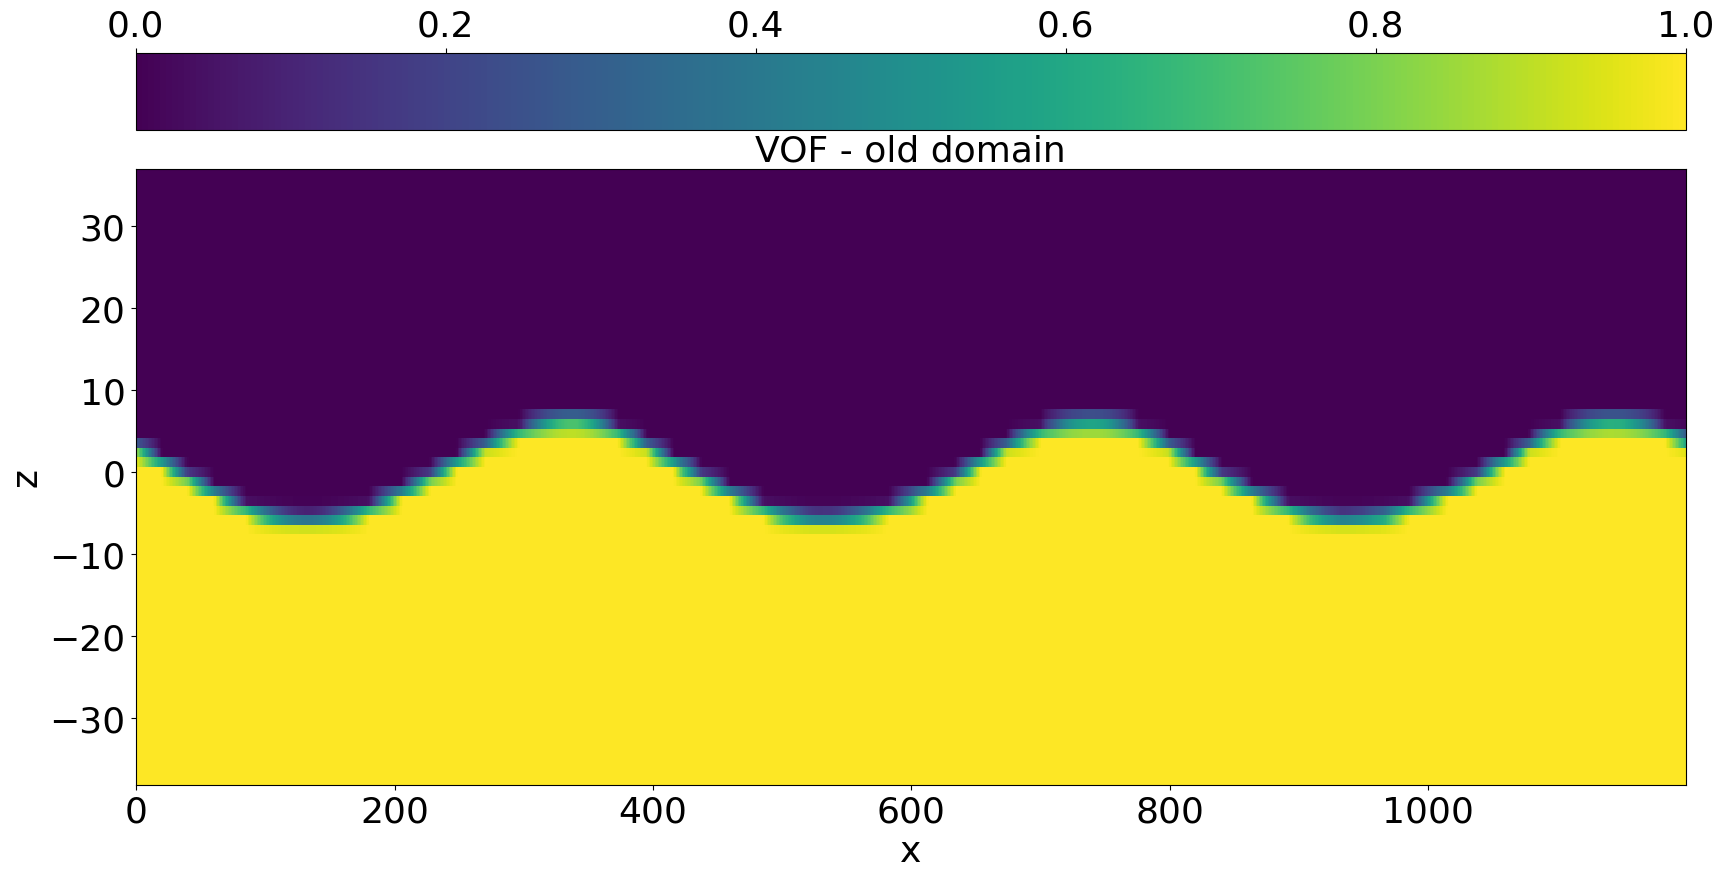

In [11]:
import matplotlib as mpl 
mpl.rcParams['lines.linewidth'] = 2 
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['axes.labelsize'] = 26
mpl.rcParams['xtick.labelsize'] = 26
mpl.rcParams['ytick.labelsize'] = 26
mpl.rcParams['legend.fontsize'] = 26

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(20,10))
zlo_plt, zhi_plt = -50, 50
data0 = ds_xz0['vof'].isel(y=yind, time=tind).sel(z=slice(zlo_plt,zhi_plt)).values.T
cm = ax.pcolormesh(ds_xz0['x'], ds_xz0['z'].sel(z=slice(zlo_plt,zhi_plt)), data0, shading='auto', vmin=min00, vmax=max00)
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_title("VOF - old domain")
fig.colorbar(cm, ax=ax, location="top")

In [13]:
data0 = ds_xz0['vof'].isel(y=yind, time=tind).sel(z=slice(zlo_plt,zhi_plt)).values

In [14]:
data0.shape

(1024, 64)

Text(0, 0.5, 'VOF')

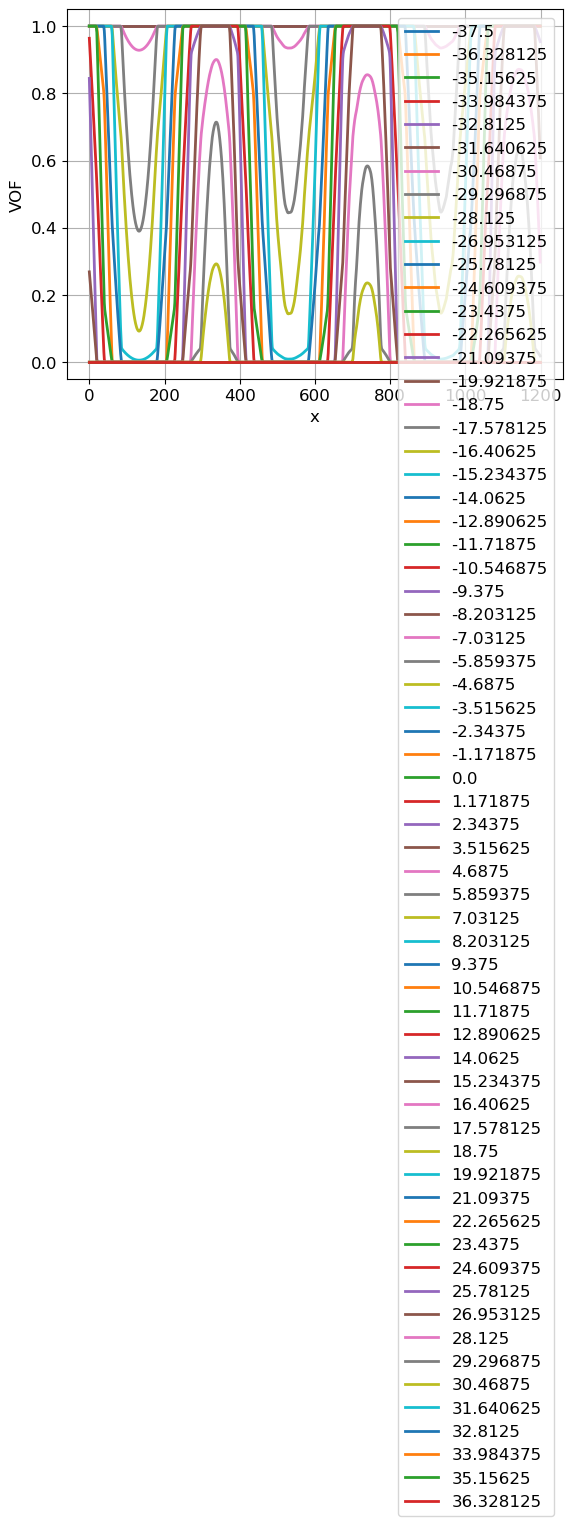

In [15]:
mpl.rcParams['lines.linewidth'] = 2 
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

xdir = ds_xz0['x']
plt.figure()
plt.grid()
for i in range(data0.shape[1]):
    plt.plot(xdir,data0[:,i],label=ds_xz0['z'].sel(z=slice(zlo_plt,zhi_plt)).values[i])
plt.legend()
plt.xlabel('x')
plt.ylabel('VOF')

In [16]:
Nx = data0.shape[0]
Nz = data0.shape[1]

vof_data = np.copy(data0[:,:])
flag_indices = []

sum = 0
for i in range(Nz):
    vof_data_at_zloc = vof_data[:,i]
    if (np.all(np.abs(vof_data_at_zloc-0.0) < 1.0E-3) or np.all(np.abs(vof_data_at_zloc-1.0) < 1.0E-3)):
        continue
    else:
        flag_indices.append(i)
        sum = sum + 1

In [17]:
vof_average = np.zeros(Nx)
for i in range(Nx):
    avg = 0.0
    vof_data_at_x = vof_data[i,:]
    for j in range(Nz):
        if j in flag_indices:
            avg = avg + vof_data_at_x[j]      
    vof_average[i] = avg / sum

Text(0, 0.5, 'VOF')

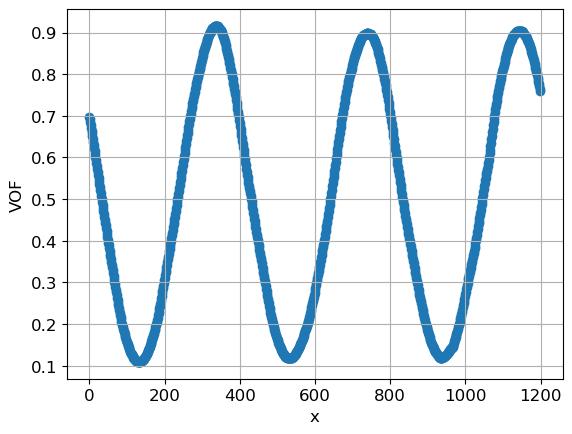

In [18]:
plt.figure()
plt.grid()
plt.scatter(xdir,vof_average)
#plt.legend()
plt.xlabel('x')
plt.ylabel('VOF')

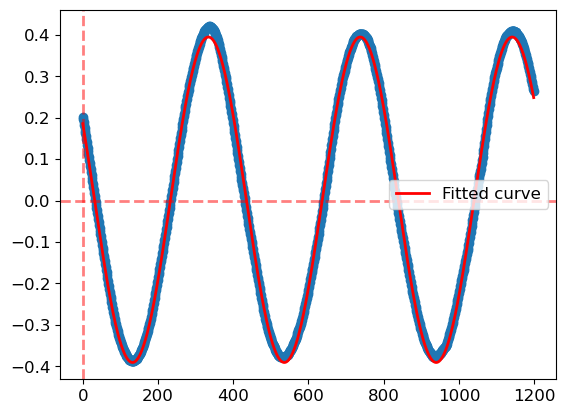

404.296875
-5.769029129409908e-09
30.46875
0.4735154144541137
27.130434782608695


In [19]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

vof_avg = np.average(vof_average)
vof_shift_down = vof_average-vof_avg

def cos_func(x, A, omega, phi, C):
    return A * np.cos(omega * x + phi) + C

def sine_func(x, A, omega, phi, offset):
    return A * np.sin(omega * x + phi) + offset

#popt, _ = curve_fit(cos_func, xdir, vof_shift_down, p0=[0.01, -0.017, 0.1, 0.01])
popt, _ = curve_fit(sine_func, xdir, vof_shift_down, p0=[0.01, -0.017, 0.1, 0.01])
vof_sin_fitting = sine_func(xdir, *popt)
vof_sin_fitting_mean = np.mean(vof_sin_fitting)
plt.scatter(xdir,vof_shift_down)
plt.plot(xdir, vof_sin_fitting, 'r-', label='Fitted curve')
plt.axhline(y=vof_sin_fitting_mean, color='red', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

from scipy.signal import find_peaks
peaks, _ = find_peaks(vof_sin_fitting)
max_values = vof_sin_fitting[peaks]
coordinates = max_values.coords["x"].values

# Period of oscillation and frequency:
X = coordinates[1]-coordinates[0] # This is the time period
print(X)
frequency = 1/X

EPS = 1.0E-2
print(vof_sin_fitting_mean.values)

i = 0
zero_cross_loc = []
vof_shift = vof_sin_fitting-vof_sin_fitting_mean

for value in vof_shift:
    fitted_value = value.values
    if abs(fitted_value) < EPS:
        zero_cross_loc.append(xdir.values[i])
    i = i + 1

print(zero_cross_loc[0])
phase = 2*np.pi*frequency*zero_cross_loc[0]
print(phase)
print(np.degrees(phase))

In [ ]:
with Dataset(f0, "r") as template:
    print(template.variables)
    xvelocity_input = template.variables['velocityx'][:,:,:]
    yvelocity_input = template.variables['velocityy'][:,:,:]
    zvelocity_input = template.variables['velocityz'][:,:,:]
    vof_input = template.variables['vof'][:,:,:]
    time = template.variables['time'][::10]
    zlocs = template.variables['z'][:]

print(time.shape)
print(vof_input.shape)
vof_one_cell = vof_input[:,640,24]
vof_one_cell.shape

In [ ]:
vof_vs_time_at_all_z = vof_input[:,640,:] # the "y" location corresponds to the mid-point
print(vof_vs_time_at_all_z.shape)
print(np.size(vof_vs_time_at_all_z[0,:]))

plt.figure(figsize=(12, 12))
plt.grid()
# looping between specific values of z in the vicinity of the interface
for i in range(10,38,1):
    plt.plot(time, vof_vs_time_at_all_z[:,i],label=zlocs[i])
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('VOF')

In [ ]:
vof_vs_time_specific_zloc = vof_vs_time_at_all_z[:,10:38]
flag_indices = []

# checking if the VOF profile at a specific z is all 0 or 1
# If false, flag the index
sum = 0
for i in range(vof_vs_time_specific_zloc.shape[1]):
    vof_data_at_zloc = vof_vs_time_specific_zloc[:,i]
    if (np.all(np.abs(vof_data_at_zloc-0.0) < 1.0E-3) or np.all(np.abs(vof_data_at_zloc-1.0) < 1.0E-3)):
        continue
    else:
        flag_indices.append(i)
        sum = sum + 1
print(sum)

In [ ]:
# For each time instance, find the average value of VOF across all z
ntime_steps = np.size(time)
vof_average = np.zeros(ntime_steps)
for i in range(ntime_steps):
    avg = 0.0
    vof_data_at_time = vof_vs_time_specific_zloc[i,:]
    for j in range(vof_vs_time_specific_zloc.shape[1]):
        if j in flag_indices:
            avg = avg + vof_data_at_time[j]      
    vof_average[i] = avg / sum

In [ ]:
plt.figure()
plt.grid()
plt.scatter(time,vof_average)
#plt.legend()
plt.xlabel('time (s)')
plt.ylabel('VOF')

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

vof_avg = np.average(vof_average)
vof_shift_down = vof_average-vof_avg
time = time - time[0]

def cos_func(x, A, omega, phi, C):
    return A * np.cos(omega * x + phi) + C

def sine_func(x, A, omega, phi, offset):
    return A * np.sin(omega * x + phi) + offset

#popt, _ = curve_fit(cos_func, xdir, vof_shift_down, p0=[0.01, -0.017, 0.1, 0.01])
popt, _ = curve_fit(sine_func, time, vof_shift_down, p0=[0.1, 0.4, 0.1, 0.01])
vof_sin_fitting = sine_func(time, *popt)
vof_sin_fitting_mean = np.mean(vof_sin_fitting)
plt.scatter(time,vof_shift_down)
plt.plot(time, vof_sin_fitting, 'r-', label='Fitted curve')
plt.axhline(y=vof_sin_fitting_mean, color='red', linestyle='--', alpha=0.5)
#plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
plt.xlabel('time (s)')
plt.ylabel('VOF')
plt.legend()
plt.show()

from scipy.signal import find_peaks
peaks, _ = find_peaks(vof_sin_fitting)
max_values = vof_sin_fitting[peaks]
print(max_values)



In [ ]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(vof_sin_fitting)
max_values = vof_sin_fitting[peaks]
print(max_values)
print(time[peaks])
coordinates = time[peaks]

# Period of oscillation and frequency:
X = coordinates[1]-coordinates[0] # This is the time period

print("")
print("time period")
print(X)
frequency = 1/X

EPS = 1.0E-2

i = 0
zero_cross_loc = []
vof_shift = vof_sin_fitting-vof_sin_fitting_mean

print("")
print("time[0]")
print(time[0])

print("")

for value in vof_shift:
    fitted_value = value
    if abs(fitted_value) < EPS:
        zero_cross_loc.append(time[i])
    i = i + 1

print(zero_cross_loc[0])
phase = 2*np.pi*frequency*zero_cross_loc[0]
print(phase)
print(np.degrees(phase))